In [1]:
import os, json
import pandas as pd

from data.paths import TabularDataPaths
from utils import print as print_f
from utils.preprocessing import get_split_list
from data.constants import XAMI_MIMIC_PATH, SPREADSHEET_FOLDER
from utils.init import reproducibility

In [2]:
# load reflacx dataset to see the original data distribution

In [14]:
seed = 0
reproducibility(0)
XAMI_MIMIC_PATH_str = "{XAMI_MIMIC_PATH}"

In [15]:
reflacx_meta_df = pd.read_csv(
    TabularDataPaths.SpreadSheet.get_sreadsheet(
        XAMI_MIMIC_PATH, TabularDataPaths.SpreadSheet.REFLACX.metadata,
    )
)
reflacx_meta_df.head(5)


,Unnamed: 0,id,split,eye_tracking_data_discarded,image,dicom_id,subject_id,image_size_x,image_size_y,Airway wall thickening,...,Support devices,Wide mediastinum,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality
0,0,P102R108387,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,P102R379837,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,P102R558314,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,4.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,P102R765317,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,P102R915878,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
labels_cols = [
    "Airway wall thickening",
    "Atelectasis",
    "Consolidation",
    "Enlarged cardiac silhouette",
    "Fibrosis",
    "Fracture",
    "Groundglass opacity",
    "Pneumothorax",
    "Pulmonary edema",
    "Wide mediastinum",
    "Abnormal mediastinal contour",
    "Acute fracture",
    "Enlarged hilum",
    "Quality issue",
    "Support devices",
    "Hiatal hernia",
    "High lung volume / emphysema",
    "Interstitial lung disease",
    "Lung nodule or mass",
    "Pleural abnormality",
]


## inlcude the repetitive columns.
all_disease_cols = [
    "Airway wall thickening",
    "Atelectasis",
    "Consolidation",
    "Emphysema",
    "Enlarged cardiac silhouette",
    "Fibrosis",
    "Fracture",
    "Groundglass opacity",
    "Mass",
    "Nodule",
    "Other",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary edema",
    "Wide mediastinum",
    "Abnormal mediastinal contour",
    "Acute fracture",
    "Enlarged hilum",
    "Hiatal hernia",
    "High lung volume / emphysema",
    "Interstitial lung disease",
    "Lung nodule or mass",
    "Pleural abnormality",
]


In [17]:
def checkMissingValue(df):
    print(
        [
            (col, sum(df[col].isna()))
            for col in df.columns
            if df[col].isna().any()
        ]
    )

In [18]:
# Checking the columns that contian nan values.
print_f.print_title("Columns have NaN value in REFLACX metadata")
checkMissingValue(reflacx_meta_df)

====================Columns have NaN value in REFLACX metadata====================
[('Airway wall thickening', 2757), ('Emphysema', 2757), ('Fibrosis', 2757), ('Fracture', 2757), ('Mass', 2757), ('Nodule', 2757), ('Other', 2839), ('Pleural effusion', 2757), ('Pleural thickening', 2757), ('Quality issue', 2757), ('Wide mediastinum', 2757), ('Abnormal mediastinal contour', 295), ('Acute fracture', 295), ('Enlarged hilum', 295), ('Hiatal hernia', 295), ('High lung volume / emphysema', 295), ('Interstitial lung disease', 295), ('Lung nodule or mass', 295), ('Pleural abnormality', 295)]


In [19]:
# Filling nan for numerical cols.
reflacx_meta_df[all_disease_cols] = reflacx_meta_df[all_disease_cols].fillna(0)

# Folling nan for boolean cols.
reflacx_meta_df[["Quality issue", "Support devices"]] = reflacx_meta_df[
    ["Quality issue", "Support devices"]
].fillna(False)



In [20]:
print_f.print_title("Columns have missing value in REFLACX metadata.")

checkMissingValue(reflacx_meta_df)


====================Columns have missing value in REFLACX metadata.====================
[]


In [21]:
reflacx_meta_df["Lung nodule or mass"] = reflacx_meta_df[
    ["Lung nodule or mass", "Mass", "Nodule"]
].max(axis=1)
del reflacx_meta_df["Mass"]
del reflacx_meta_df["Nodule"]

reflacx_meta_df["High lung volume / emphysema"] = reflacx_meta_df[
    ["High lung volume / emphysema", "Emphysema"]
].max(axis=1)
del reflacx_meta_df["Emphysema"]


reflacx_meta_df["Pleural abnormality"] = reflacx_meta_df[
    ["Pleural abnormality", "Pleural thickening", "Pleural effusion"]
].max(axis=1)
del reflacx_meta_df["Pleural thickening"]
del reflacx_meta_df["Pleural effusion"]



In [22]:
from collections import OrderedDict

count_map = dict((reflacx_meta_df[labels_cols] >0 ).sum(axis=0))
counting_map = OrderedDict({k: v for k, v in sorted(count_map.items(), key=lambda item: item[1])})

In [23]:
from data.constants import DEFAULT_REFLACX_LABEL_COLS

label_counts = {}
for col in DEFAULT_REFLACX_LABEL_COLS:
    label_counts[col] = counting_map[col]


In [24]:
label_counts

{'Enlarged cardiac silhouette': 716,
 'Atelectasis': 845,
 'Pleural abnormality': 936,
 'Consolidation': 818,
 'Pulmonary edema': 428}

In [25]:
import matplotlib.pyplot as plt

<BarContainer object of 5 artists>

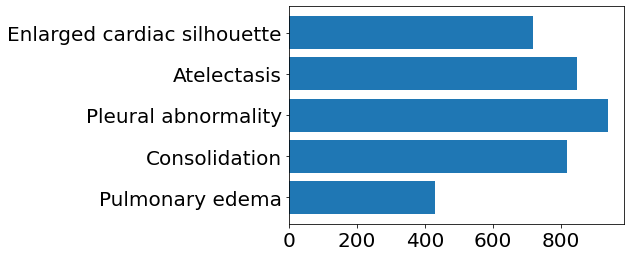

In [35]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure()
keys_list = list(reversed(list(label_counts.keys())))
plt.barh(keys_list, [ label_counts[k] for k in keys_list])

In [37]:
reversed(list(label_counts.keys()))

In [38]:
preprocessed_df = pd.read_csv(os.path.join(SPREADSHEET_FOLDER, "reflacx_with_clinical.csv"))

In [39]:
preprocessed_df.head(5)

,Unnamed: 0,index,id,dicom_id,subject_id,stay_id,study_id,image_path,ViewPosition,image_size_x,...,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality,Fracture,split
0,0,0,P102R108387,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
1,1,1,P102R379837,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,val
2,2,2,P102R558314,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,3,3,P102R765317,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,train
4,4,4,P102R915878,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [40]:
from data.constants import DEFAULT_REFLACX_LABEL_COLS


preprocessed_count_map = dict((preprocessed_df[labels_cols] >0 ).sum(axis=0))
preprocessed_counting_map = OrderedDict({k: v for k, v in sorted(preprocessed_count_map.items(), key=lambda item: item[1])})

preprocessed_label_counts = {}
for col in DEFAULT_REFLACX_LABEL_COLS:
    preprocessed_label_counts[col] = preprocessed_counting_map[col]


In [41]:
preprocessed_label_counts

{'Enlarged cardiac silhouette': 154,
 'Atelectasis': 143,
 'Pleural abnormality': 138,
 'Consolidation': 112,
 'Pulmonary edema': 85}

<BarContainer object of 5 artists>

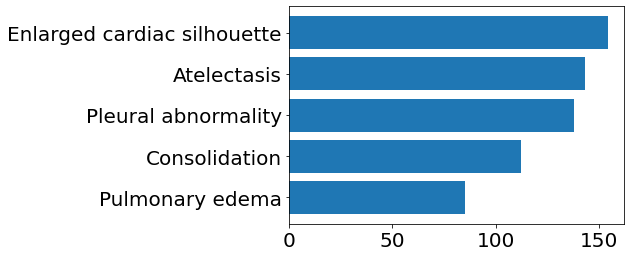

In [42]:
fig = plt.figure()
keys_list = list(reversed(list(preprocessed_label_counts.keys())))
plt.barh(keys_list, [ preprocessed_label_counts[k] for k in keys_list])

In [43]:
preprocessed_df

,Unnamed: 0,index,id,dicom_id,subject_id,stay_id,study_id,image_path,ViewPosition,image_size_x,...,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality,Fracture,split
0,0,0,P102R108387,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
1,1,1,P102R379837,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,val
2,2,2,P102R558314,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,3,3,P102R765317,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,train
4,4,4,P102R915878,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,665,3020,P300R833708,a2fe8aae-2fe32131-b47c4e5b-090f4c13-88e7ac97,19875621,32582616,55102074,{XAMI_MIMIC_PATH}\patient_19875621\CXR-JPG\s55...,PA,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,val
666,666,3023,P300R918521,a2a80c63-8b9575dc-bc08895e-40392d6a-d7fc17d5,19884194,36719043,57912042,{XAMI_MIMIC_PATH}\patient_19884194\CXR-JPG\s57...,AP,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
667,667,3027,P300R611251,2b20dcdf-4077bc16-48fc8eb5-265ef218-f6552cb0,19906407,33352559,57296330,{XAMI_MIMIC_PATH}\patient_19906407\CXR-JPG\s57...,AP,2881,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,val
668,668,3028,P300R519683,92134f99-0e73faba-1280ad81-218c68ba-933a85c5,19907884,39112538,57427881,{XAMI_MIMIC_PATH}\patient_19907884\CXR-JPG\s57...,PA,2544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [44]:
from data.constants import DEFAULT_MIMIC_CLINICAL_NUM_COLS, DEFAULT_REFLACX_PATH_COLS


<AxesSubplot:>

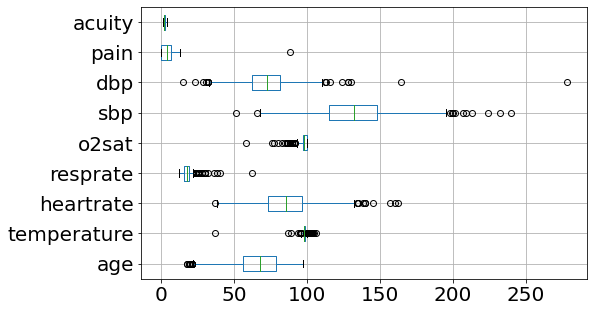

In [45]:
plt.figure(figsize=(8, 5))
preprocessed_df[DEFAULT_MIMIC_CLINICAL_NUM_COLS].boxplot(vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x1eae767be20>,
 'caps': [<matplotlib.lines.Line2D at 0x1eae768d400>,
 'boxes': [<matplotlib.lines.Line2D at 0x1eae767bb20>,
 'medians': [<matplotlib.lines.Line2D at 0x1eae768d9a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1eae768dc70>,
 'means': []}

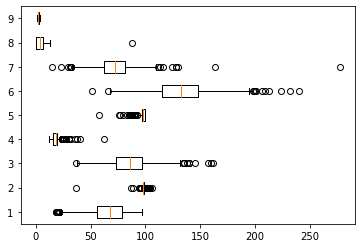

In [82]:
plt.boxplot(DEFAULT_MIMIC_CLINICAL_NUM_COLS, preprocessed_df[DEFAULT_MIMIC_CLINICAL_NUM_COLS], vert=False)

In [58]:
from pathlib import Path


In [59]:
for p_col in DEFAULT_REFLACX_PATH_COLS:
    if p_col in reflacx_meta_df.columns:
        if p_col == "bbox_paths":

            def apply_bbox_paths_transform(input_paths_str: str) -> List[str]:
                input_paths_list = json.loads(input_paths_str)
                replaced_path_list = [
                    p.replace("{XAMI_MIMIC_PATH}", XAMI_MIMIC_PATH)
                    for p in input_paths_list
                ]
                return replaced_path_list

            apply_fn = lambda x: apply_bbox_paths_transform(x)

        else:
            apply_fn = lambda x: str(
                Path(x.replace("{XAMI_MIMIC_PATH}", XAMI_MIMIC_PATH))
            )

        reflacx_meta_df[p_col] = reflacx_meta_df[p_col].apply(apply_fn)

In [70]:
all_bbox_num = [len(pd.read_csv(preprocessed_df['anomaly_location_ellipses_path'].iloc[i])) for i in range(len(preprocessed_df))]
max(all_bbox_num)

6

In [71]:
### Average bbox numbers

import numpy as np
np.mean(all_bbox_num)

# preprossed: 1.3522388059701493

1.3522388059701493

In [74]:
reflacx_meta_df["anomaly_location_ellipses_path"] = (
    f"{XAMI_MIMIC_PATH_str}\patient_"
    + reflacx_meta_df["subject_id"].astype(str)
    + "\REFLACX\\"
    + reflacx_meta_df["id"].astype(str)
    + "\\anomaly_location_ellipses.csv"
)


In [75]:
for p_col in DEFAULT_REFLACX_PATH_COLS:
    if p_col in reflacx_meta_df.columns:
        if p_col == "bbox_paths":

            def apply_bbox_paths_transform(input_paths_str: str) -> List[str]:
                input_paths_list = json.loads(input_paths_str)
                replaced_path_list = [
                    p.replace("{XAMI_MIMIC_PATH}", XAMI_MIMIC_PATH)
                    for p in input_paths_list
                ]
                return replaced_path_list

            apply_fn = lambda x: apply_bbox_paths_transform(x)

        else:
            apply_fn = lambda x: str(
                Path(x.replace("{XAMI_MIMIC_PATH}", XAMI_MIMIC_PATH))
            )

        reflacx_meta_df[p_col] = reflacx_meta_df[p_col].apply(apply_fn)

In [76]:
all_bbox_num = [len(pd.read_csv(reflacx_meta_df['anomaly_location_ellipses_path'].iloc[i])) for i in range(len(reflacx_meta_df))]
max(all_bbox_num)

8

In [77]:
np.mean(all_bbox_num)
## for all reflacx

# original: "1.6671035386631716"

1.6671035386631716

In [78]:
len(reflacx_meta_df)

3052

In [79]:
ed_triage_df = pd.read_csv("D:\mimic-iv-ed-1.0\mimic-iv-ed-1.0\ed\\triage.csv")


In [80]:
len(ed_triage_df)

448972

In [88]:
len(preprocessed_df)

670

In [91]:
# for unique cases, it's 590

len(preprocessed_df["dicom_id"].unique())

590